# Self-Attention and Positional Encoding

In deep learning, we often use CNNs or RNNs to encode sequences.
Now with attention mechanisms in mind, 
imagine feeding a sequence of tokens 
into an attention mechanism
such that at every step,
each token has its own query, keys, and values.
Here, when computing the value of a token's representation at the next layer,
the token can attend (via its query vector) to any other's token 
(matching based on their key vectors).
Using the full set of query-key compatibility scores,
we can compute, for each token, a representation
by building the appropriate weighted sum
over the other tokens. 
Because every token is attending to each other token
(unlike the case where decoder steps attend to encoder steps),
such architectures are typically described as *self-attention* models :cite:`Lin.Feng.Santos.ea.2017,Vaswani.Shazeer.Parmar.ea.2017`, 
and elsewhere described as *intra-attention* model :cite:`Cheng.Dong.Lapata.2016,Parikh.Tackstrom.Das.ea.2016,Paulus.Xiong.Socher.2017`.
In this section, we will discuss sequence encoding using self-attention,
including using additional information for the sequence order.


In [8]:
using Pkg; Pkg.activate("../../d2lai")
using LinearAlgebra
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN


  Activating project at `/workspace/workspace/d2l-julia/d2lai`


## Self-Attention

Given a sequence of input tokens
$\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^d$ ($1 \leq i \leq n$),
its self-attention outputs
a sequence of the same length
$\mathbf{y}_1, \ldots, \mathbf{y}_n$,
where

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$

according to the definition of attention pooling in
:eqref:`eq_attention_pooling`.
Using multi-head attention,
the following code snippet
computes the self-attention of a tensor
with shape (batch size, number of time steps or sequence length in tokens, $d$).
The output tensor has the same shape.

In [4]:
num_hiddens, num_heads = 100, 5
attention = d2lai.MultiHeadedAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, [3, 2]
X = ones(num_hiddens, num_queries, batch_size)
out, attention_weights = attention(X, X, X, valid_lens)
@assert size(out) == (num_hiddens, num_queries, batch_size)

## Comparing CNNs, RNNs, and Self-Attention

Let's
compare architectures for mapping
a sequence of $n$ tokens
to another one of equal length,
where each input or output token is represented by
a $d$-dimensional vector.
Specifically,
we will consider CNNs, RNNs, and self-attention.
We will compare their
computational complexity, 
sequential operations,
and maximum path lengths.
Note that sequential operations prevent parallel computation,
while a shorter path between
any combination of sequence positions
makes it easier to learn long-range dependencies 
within the sequence :cite:`Hochreiter.Bengio.Frasconi.ea.2001`.


![Comparing CNN (padding tokens are omitted), RNN, and self-attention architectures.](../img/cnn-rnn-self-attention.svg)
:label:`fig_cnn-rnn-self-attention`



Let's regard any text sequence as a "one-dimensional image". Similarly, one-dimensional CNNs can process local features such as $n$-grams in text.
Given a sequence of length $n$,
consider a convolutional layer whose kernel size is $k$,
and whose numbers of input and output channels are both $d$.
The computational complexity of the convolutional layer is $\mathcal{O}(knd^2)$.
As :numref:`fig_cnn-rnn-self-attention` shows,
CNNs are hierarchical,
so there are $\mathcal{O}(1)$ sequential operations
and the maximum path length is $\mathcal{O}(n/k)$.
For example, $\mathbf{x}_1$ and $\mathbf{x}_5$
are within the receptive field of a two-layer CNN
with kernel size 3 in :numref:`fig_cnn-rnn-self-attention`.

When updating the hidden state of RNNs,
multiplication of the $d \times d$ weight matrix
and the $d$-dimensional hidden state has 
a computational complexity of $\mathcal{O}(d^2)$.
Since the sequence length is $n$,
the computational complexity of the recurrent layer
is $\mathcal{O}(nd^2)$.
According to :numref:`fig_cnn-rnn-self-attention`,
there are $\mathcal{O}(n)$ sequential operations
that cannot be parallelized
and the maximum path length is also $\mathcal{O}(n)$.

In self-attention,
the queries, keys, and values 
are all $n \times d$ matrices.
Consider the scaled dot product attention in
:eqref:`eq_softmax_QK_V`,
where an $n \times d$ matrix is multiplied by
a $d \times n$ matrix,
then the output $n \times n$ matrix is multiplied
by an $n \times d$ matrix.
As a result,
the self-attention
has a $\mathcal{O}(n^2d)$ computational complexity.
As we can see from :numref:`fig_cnn-rnn-self-attention`,
each token is directly connected
to any other token via self-attention.
Therefore,
computation can be parallel with $\mathcal{O}(1)$ sequential operations
and the maximum path length is also $\mathcal{O}(1)$.

All in all,
both CNNs and self-attention enjoy parallel computation
and self-attention has the shortest maximum path length.
However, the quadratic computational complexity with respect to the sequence length
makes self-attention prohibitively slow for very long sequences.





## Positional Encoding


Unlike RNNs, which recurrently process
tokens of a sequence one-by-one,
self-attention ditches
sequential operations in favor of 
parallel computation.
Note that self-attention by itself
does not preserve the order of the sequence. 
What do we do if it really matters 
that the model knows in which order
the input sequence arrived?

The dominant approach for preserving 
information about the order of tokens
is to represent this to the model 
as an additional input associated 
with each token. 
These inputs are called *positional encodings*,
and they can either be learned or fixed *a priori*.
We now describe a simple scheme for fixed positional encodings
based on sine and cosine functions :cite:`Vaswani.Shazeer.Parmar.ea.2017`.

Suppose that the input representation 
$\mathbf{X} \in \mathbb{R}^{n \times d}$ 
contains the $d$-dimensional embeddings 
for $n$ tokens of a sequence.
The positional encoding outputs
$\mathbf{X} + \mathbf{P}$
using a positional embedding matrix 
$\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape,
whose element on the $i^\textrm{th}$ row 
and the $(2j)^\textrm{th}$
or the $(2j + 1)^\textrm{th}$ column is

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$
:eqlabel:`eq_positional-encoding-def`

At first glance,
this trigonometric function
design looks weird.
Before we give explanations of this design,
let's first implement it in the following `PositionalEncoding` class.


In [5]:
struct PositionalEncoding{P,D,A} <: AbstractModel 
    dropout::D 
    P::P 
    args::A
end

function PositionalEncoding(num_hiddens::Int, dropout::AbstractFloat, max_len = 1000)
    dropout = Dropout(dropout)
    P = zeros(num_hiddens, max_len, 1)
    X = reshape(collect(1:max_len), 1, :) ./ 10000 .^ ((0:2:num_hiddens-1) / num_hiddens)
    P[1:2:end, :, :] .= sin.(X)
    P[2:2:end, :, :] .= cos.(X)
    PositionalEncoding(dropout, P, (; num_hiddens, dropout, max_len))
end

function (pos::PositionalEncoding)(x)
    device = isa(x, CuArray) ? gpu : cpu
    P_device = pos.P |> device
    pos.dropout(x .+ P_device[:, 1:size(x, 2), :])
end

In the positional embedding matrix $\mathbf{P}$,
rows correspond to positions within a sequence
and columns represent different positional encoding dimensions.
In the example below,
we can see that
the $6^{\textrm{th}}$ and the $7^{\textrm{th}}$
columns of the positional embedding matrix 
have a higher frequency than 
the $8^{\textrm{th}}$ and the $9^{\textrm{th}}$
columns.
The offset between 
the $6^{\textrm{th}}$ and the $7^{\textrm{th}}$ (same for the $8^{\textrm{th}}$ and the $9^{\textrm{th}}$) columns
is due to the alternation of sine and cosine functions.

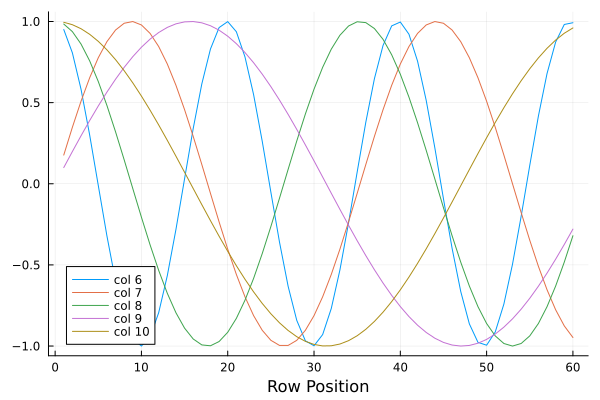

In [9]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0.3)
X = pos_encoding(zeros(encoding_dim, num_steps, 1))
P = pos_encoding.P[:, 1:size(X, 2), :]
plot(P[6:10, :, 1]', label = reshape(["col $i" for i in 6:10], 1, :), xlabel = "Row Position")

### Absolute Positional Information

To see how the monotonically decreased frequency
along the encoding dimension relates to absolute positional information,
let's print out the binary representations of $0, 1, \ldots, 7$.
As we can see, the lowest bit, the second-lowest bit, 
and the third-lowest bit alternate on every number, 
every two numbers, and every four numbers, respectively.

In [10]:
for i in 0:7
    string.(digits(i, base=2, pad = 3)) |> join |> println
end


000
100
010
110
001
101
011
111


In binary representations, a higher bit has a lower frequency than a lower bit. Similarly, as demonstrated in the heat map below, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions. Since the outputs are float numbers, such continuous representations are more space-efficient than binary representations.



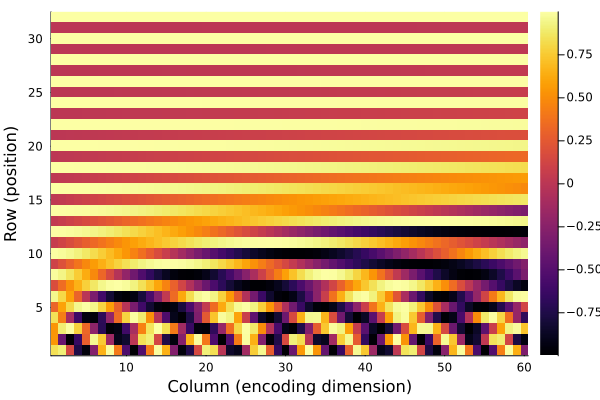

In [12]:
P_ = Flux.unsqueeze(Flux.unsqueeze(P[:, :, 1], 3), 3)

d2lai.show_heatmaps(P_, "Column (encoding dimension)", "Row (position)")


### Relative Positional Information

Besides capturing absolute positional information,
the above positional encoding
also allows
a model to easily learn to attend by relative positions.
This is because
for any fixed position offset $\delta$,
the positional encoding at position $i + \delta$
can be represented by a linear projection
of that at position $i$.


This projection can be explained
mathematically.
Denoting
$\omega_j = 1/10000^{2j/d}$,
any pair of $(p_{i, 2j}, p_{i, 2j+1})$ 
in :eqref:`eq_positional-encoding-def`
can 
be linearly projected to $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$
for any fixed offset $\delta$:

$$\begin{aligned}
\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

where the $2\times 2$ projection matrix does not depend on any position index $i$.

## Summary

In self-attention, the queries, keys, and values all come from the same place.
Both CNNs and self-attention enjoy parallel computation
and self-attention has the shortest maximum path length.
However, the quadratic computational complexity
with respect to the sequence length
makes self-attention prohibitively slow
for very long sequences.
To use the sequence order information, 
we can inject absolute or relative positional information 
by adding positional encoding to the input representations.

## Exercises

1. Suppose that we design a deep architecture to represent a sequence by stacking self-attention layers with positional encoding. What could the possible issues be?
1. Can you design a learnable positional encoding method?
1. Can we assign different learned embeddings according to different offsets between queries and keys that are compared in self-attention? Hint: you may refer to relative position embeddings :cite:`shaw2018self,huang2018music`.
